![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Managing Class Imbalance in Data

Kevin now understands CNNs and how they work, but his model is still not performing as well as he would like. He's been reading up on some techniques to improve his model's performance and is excited to try them out. 

In this notebook, we will explore two methods to help mitigate the issues that class imbalance poses: stratification and class weighting.

* **Stratification:** Ensures that class frequencies are maintained when making the training and validation datasets. In extreme cases, minority classes can be totally absent from a sampled dataset. But even in the case of less extreme imbalances and larger datasets, stratification can ensure class distributions are the same and help the model train.

* **Class weighting:** By default, the probability of any class is assumed to be equal when training a model. In the case of imbalanced classes, that can cause an issue. We can calculate per-class probabilities and use the class weights when training the model.


One particularly good resource on this is topic is Ayush Thakur and Aritra Roy Gosthipaty's article [Simple Ways to Tackle Class Imbalance](https://wandb.ai/authors/class-imbalance/reports/Simple-Ways-to-Tackle-Class-Imbalance--VmlldzoxODA3NTk) (Thakur & Gosthipaty). We recommend reading it to learn more about addressing class imbalance in a dataset.

## 1. Import the libraries we will use

In [1]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
from sklearn.model_selection import train_test_split
import datetime

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import the ImageDataGenerator class from Keras module in TensorFlow.
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

from sklearn.utils import class_weight

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhance readability. 
import helpers_01

# Load the TensorBoard notebook extension
%load_ext tensorboard

## 2. Exploring the data

As before, we'll use our helper function `helpers_01.manage_data` to make sure we have the data and set the `data_path`.

In the last notebook, Kevin noticed that his model had a big problem: it thought everything was wasps! Let's explore the data a bit and see if we can figure out why.

First let's make a histogram of the number of images in each class. That should give us a good idea of how balanced the dataset is.

In [2]:
# Chech for the data.
data_path = helpers_01.manage_data() 

Found data at data/bee_vs_wasp.


Category wasp: 4,943 images, or 43.3% of total images.
Category bee: 3,184 images, or 27.9% of total images.
Category other_insect: 2,439 images, or 21.4% of total images.
Category other_noinsect: 856 images, or 7.5% of total images.
************************************


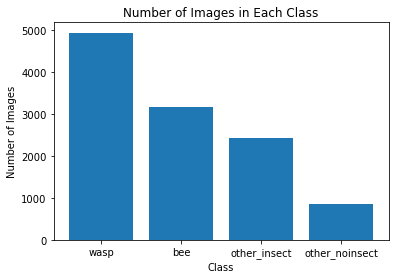

In [3]:
# Make a histogram of the number of images in each class
def make_hist_get_max(data_path):
    # Get the class names
    class_names = os.listdir(data_path)

    # Initialize an empty list to store the number of images in each class
    num_images = []

    # Loop through each class
    for class_name in class_names:
        # Get the list of images in the class
        images = os.listdir(os.path.join(data_path, class_name))
        # Append the number of images in the class to the list
        num_images.append(len(images))

    # Put the number of images in each class in descending order
    num_images, class_names = zip(*sorted(zip(num_images, class_names), reverse=True))

    total_images = sum(num_images)
    
    # Print the number of images in each class
    for i in range(len(class_names)):
        percentage = (num_images[i] / total_images) * 100
        print(f'Category {class_names[i]}: {num_images[i]:,} images, or {percentage:.1f}% of total images.')

    print("************************************")       
        
    # Create a histogram of the number of images in each class
    plt.bar(class_names, num_images)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.show()

    return num_images

num_images = make_hist_get_max(data_path)

Yikes! That's a pretty big class imbalance--there are almost 5,000 wasp images and less than 1,000 other non-insect images. Large class imbalances tend to make models biased towards the majority class. This is likely why Kevin's model was predicting everything as wasps. Let's try to fix this!

Part of the issue with imbalanced data is that the algorithm can do fairly well by never predicting the rare class(es).

As an example, let's imagine we are looking at a rare disease. If only 5% of the data are from the disease state, a model can be 95% accurate by never predicting disease. That 95% accuracy sounds good, but the model is useless!

## A note about class imbalance and the bees vs wasps dataset

One important point is that class imbalance can arise from several causes. In the case with our bee and wasp data, the fundamental issue is more of a data quality and collection issue. The real answer to solving the problem has more to do with rethinking the data:

* Do the categories really make sense? Probably not--the non-insect category is not very helpful in this case and probably causes more issues than it solves. 
* Can better data solve the problem? Most likely--we can get more images of bees and other insects.
* Are the images we have *quality images*? In many cases, no--many images would be impossible for a human to identify! We have no choice but to trust the labels.

Data quality is critical, though not something we will tackle here. Our hyperparameter tuning, stratification, and class weighting will only do so much to improve the results.

But, in many cases, class imbalance is an intrinsic part of the data. Rare diseases are a classic example of this. If a disease has an incidence of only 1%, training data for that class will be limited. In these cases, the tools we will cover may be more critical.


## 3. Stratification

The first method we will implement is stratification. Stratification ensures that when our dataset is split into training and validation sets, the class frequencies match the frequencies of the original data. This may not seem like a big issue with our dataset, but as we will see, it does help a lot! Ensuring that training and validation class frequencies are the same is important.

Let's try this out. We'll use the `train_test_split` function from `sklearn` to split the data into training and validation sets. We'll set the `stratify` parameter to the labels so that the function samples in a stratified manner.

We'll use a slightly modified version of the `load_display_data` function we used in the first notebook. It is now in the [`helpers_02_1`](helpers_02_1.py) module we imported. We will pass `show_pictures=False` to skip that.

You can look in the [`helpers_02_1`](helpers_02_1.py) file for the full code, but the code for stratifying is here:

```python
 if stratify: # Use sklearn's train_test_split function to split the data 
                 # into training and testing sets
        # Split the data in a stratified manner
        X_train, X_val, y_train, y_val = train_test_split(images, labels, 
                                test_size=0.2, stratify=labels)
```


In [4]:
# Load the data, this updated function changes the code to accommodate stratification
# and using class weights. Checkout the file if you want.
data_train, data_valid = helpers_01.load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=False, stratify=True)

******************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? True
  - Returning class counts for later use? False
******************************************************************

For the full dataset:
Number of wasp images: 4943, or 43.3%
Number of other_insect images: 2439, or 21.4%
Number of bee images: 3184, or 27.9%
Number of other_noinsect images: 856, or 7.5%
Found 9137 validated image filenames belonging to 4 classes.
Found 2284 validated image filenames belonging to 4 classes.

For the training dataset:
Number of wasp images: 3954, or 43.3%
Number of other_insect images: 1951, or 21.4%
Number of bee images: 2547, or 27.9%
Number of other_noinsect images: 685, or 7.5%


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [5]:
# This is the same model we had at the end of notebook 01_bees_vs_wasps.ipynb
# The model summary is shown, but model definition code is now moved to the 
# helpers_02_1.py file.

model = helpers_01.make_model()
model.summary()

*****************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
*****************************************************************


2024-10-02 14:12:39.574529: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 20, 20, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

2024-10-02 14:12:41.226889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [6]:
# compile and train the model
# Due to change in dataset format, we change to categorical_crossentropy loss. 
# This is the same loss function except in the format of the labels

model, history = helpers_01.compile_train_model(data_train, data_valid, model, 
                        log_name='stratify', loss='categorical_crossentropy')

******************************************************************
Compile and Train the model:
  - Using the loss function: categorical_crossentropy.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
   -Using class weights: {0: 1, 1: 1, 2: 1, 3: 1})
  - Using these callbacks: []
******************************************************************
Epoch 1/10


2024-10-02 14:12:43.852898: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-10-02 14:12:46.998359: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


286/286 [==============================] - 65s 208ms/step - loss: 1.0438 - accuracy: 0.5606 - val_loss: 0.9060 - val_accuracy: 0.6397
Epoch 2/10
286/286 [==============================] - 35s 121ms/step - loss: 0.8539 - accuracy: 0.6620 - val_loss: 0.8304 - val_accuracy: 0.6791
Epoch 3/10
286/286 [==============================] - 35s 122ms/step - loss: 0.7693 - accuracy: 0.6946 - val_loss: 0.7825 - val_accuracy: 0.6751
Epoch 4/10
286/286 [==============================] - 35s 124ms/step - loss: 0.7212 - accuracy: 0.7143 - val_loss: 0.7375 - val_accuracy: 0.7018
Epoch 5/10
286/286 [==============================] - 35s 122ms/step - loss: 0.6781 - accuracy: 0.7367 - val_loss: 0.6907 - val_accuracy: 0.7294
Epoch 6/10
286/286 [==============================] - 35s 122ms/step - loss: 0.6537 - accuracy: 0.7454 - val_loss: 0.6621 - val_accuracy: 0.7417
Epoch 7/10
286/286 [==============================] - 35s 123ms/step - loss: 0.6163 - accuracy: 0.7618 - val_loss: 0.6498 - val_accuracy: 0.7

******************************************************************
Evaluate the model:
******************************************************************
72/72 [==============================] - 7s 96ms/step - loss: 0.5949 - accuracy: 0.7771
Test loss: 0.5948641896247864
Test accuracy: 0.7771453857421875


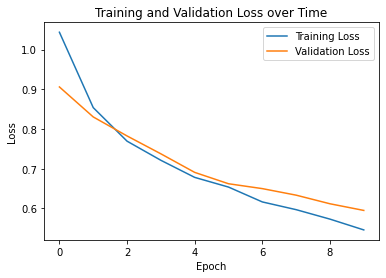

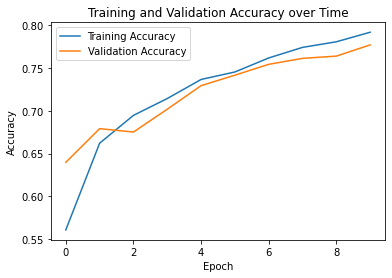

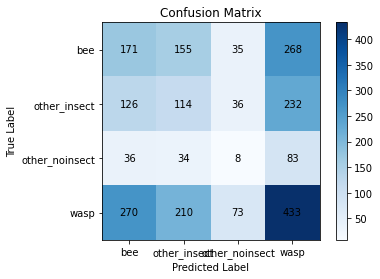

In [29]:
# Evaluate the model
helpers_01.evaluate_model(data_valid, model, history)

## 4. Class weighting

The next method we will implement is class weighting. As Thakur & Gosthipaty write:
> One of the easiest ways to counter class imbalance is to use class weights wherein we give different weightage to different classes. The number of samples in the classes is considered while computing the class weights. We apply more significant weight to a minority class, which places more emphasis on that class. The classifier thus learns equally from both the classes. [Their example had only two classes]
>
> Class weights regularize the loss function. By misclassifying the minority class, a higher loss is incurred by the model since the minority class has a higher weight. This forces the model to learn representations for the minority class. This, however, comes at a price of slightly reduced performance for the majority class.

Note that they were dealing with two classes; here, we have four. Our code will handle datasets with different numbers of classes.



In [30]:
data_train, data_valid, cls_counts = helpers_01.load_display_data(data_path, 
                batch_size=32, shape=(80,80,3), show_pictures=False, 
                stratify=True, return_cls_counts=True)

******************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? True
  - Returning class counts for later use? True
******************************************************************

For the full dataset:
Number of wasp images: 4943, or 43.3%
Number of other_insect images: 2439, or 21.4%
Number of bee images: 3184, or 27.9%
Number of other_noinsect images: 856, or 7.5%
Found 9137 validated image filenames belonging to 4 classes.
Found 2284 validated image filenames belonging to 4 classes.

For the training dataset:
Number of wasp images: 3954, or 43.3%
Number of other_insect images: 1951, or 21.4%
Number of bee images: 2547, or 27.9%
Number of other_noinsect images: 685, or 7.5%

Class counts being returned: {'wasp': 4943, 'other_insect': 2439, 'bee': 3184, 'other_noinsect': 856}.


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


## 5. Make our model
We'll make a fresh model to test out our class weighting method. The architecture will be the same as the previous CNNs we've made with a few DropOut layers to help prevent overfitting. The code for the model is in the `helpers_02_1.py` file to keep this notebook clean.

One reason to create a fresh model is that we need to clear the session to ensure that the model is created from scratch. If we don't do this, the model will be created with the weights from the previous model. This is not what we want! There are other ways to handle this, but this is way is pretty simple.


In [31]:
# Make the model

model = helpers_01.make_model()
model.summary()

*****************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
*****************************************************************
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                    

## 6. Compile and train the model

This time we will have both stratification and class weighting turned on. Finger's crossed that this will help our model with its wasp obsession!

In [ ]:

model, history = helpers_01.compile_train_model(data_train, data_valid, model,
                        weights=cls_counts, log_name='weights',
                        loss='categorical_crossentropy')

['bee', 'other_insect', 'other_noinsect', 'wasp']
******************************************************************
Compile and Train the model:
  - Using the loss function: categorical_crossentropy.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
   -Using class weights: {0: 0.8968278894472361, 1: 1.1707667076670767, 2: 3.3358644859813085, 3: 0.5776856160226583})
  - Using these callbacks: []
******************************************************************
Epoch 1/10
286/286 [==============================] - 35s 123ms/step - loss: 1.0974 - accuracy: 0.4862 - val_loss: 0.9640 - val_accuracy: 0.5976
Epoch 2/10
286/286 [==============================] - 35s 121ms/step - loss: 0.8575 - accuracy: 0.6191 - val_loss: 0.8695 - val_accuracy: 0.6611
Epoch 3/10
184/286 [==================>...........] - ETA: 9s - loss: 0.8001 - accuracy: 0.6500

## 7. Evaluate the model

Now that we have trained our model, let's evaluate how it performs compared to the previous model that only used stratification.


In [ ]:
helpers_01.evaluate_model(data_valid, model, history)

## 8. Conclusion

From the evaluation data above, stratification alone was more helpful than stratification and class weighting combined. Of note, in both scenarios training and validation accuracy we both improving together. This is a good sign that the model is learning and not just memorizing the training data. When a model is still showing improvement in both training and validation, a simple thing to try is to train it for more epochs.

In addition to training for more epochs, what else could we do to improve the model? If you have time, experiment with different hyperparameters!
